# Note

In [ ]:
%%capture
%pip install numpy scipy pandas scikit-learn matplotlib torch

# Recap

In the previous module we implemented forward propagation. We implemented forward propagation using numpy arrays and with PyTorch library. We also implemented learned about neural network architecture and nodes and edges.

## Data

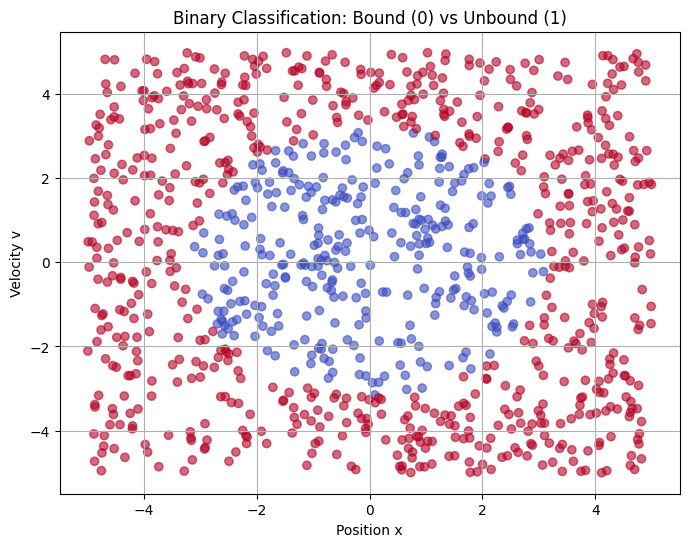

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gdown
import numpy as np
from sklearn.model_selection import train_test_split

# Parameters
k = 1.0  # spring constant
E_thresh = 5.0  # energy threshold
n_samples = 1000
mass = 1.0

# Generate random (x, v) values
position = np.random.uniform(-5, 5, n_samples)
velocity = np.random.uniform(-5, 5, n_samples)

# Compute energies
potential_energy = 0.5 * k * position**2
kinetic_energy = 0.5 *mass* velocity**2
total_energy = kinetic_energy + potential_energy

# Generate labels: 0 if bounded (E <= E_threshold), 1 if unbounded (E > E_threshold)
labels = (total_energy > E_thresh).astype(int)

# Create a DataFrame
df = pd.DataFrame({
    'Position': position,
    'Velocity': velocity,
    'Kinetic Energy': kinetic_energy,
    'Potential Energy': potential_energy,
    'Mechanical Energy': total_energy,
    'Label': labels
})

# Plotting the data
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df['Position'], df['Velocity'], c=df['Label'], cmap='coolwarm', alpha=0.6)
plt.xlabel('Position x')
plt.ylabel('Velocity v')
plt.title('Binary Classification: Bound (0) vs Unbound (1)')
plt.grid(True)
plt.show()

## Train Test Split

In [ ]:
#Extract the position and velocity data.
position = df['Position'].to_numpy()
velocity = df['Velocity'].to_numpy()

#Extract the Label Data
labels = df['Label'].to_numpy()
#Convert everything to numpy.

#Stack the position and velocity data to make a feature dataset

features = np.hstack((position.reshape((1000,1)), velocity.reshape((1000,1))))
labels = labels.reshape((1000,1))

#Make sure the dimensions of the input and output are aligned.
features.shape, labels.shape

#Split data set into train and test.
#Also add the argument random_state = 42, if you don't you'll get different answers
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2, random_state = 42)

## Activation Function

In [ ]:
#Brief Warmup Implement relu,
# sigmoid, sigmoid derivative, tanh, tanh derivative.

def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return (z > 0).astype(float)

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_derivative(z):
    return sigmoid(z) * (1 - sigmoid(z))

def tanh(z):
    return (np.e**z-np.e**(-z))/(np.e**z+np.e**(-z))

def tanh_derivative(z):
    return 1-tanh(z)**2

## Forward Pass

In [ ]:
def bce_loss(pred, y):
    eps = 1e-15  # avoid log(0)
    pred = np.clip(pred, eps, 1 - eps)
    return -np.mean(y * np.log(pred) + (1 - y) * np.log(1 - pred))

In [ ]:
def forward_pass(x, W1, b1, W2, b2, W3, b3):
    """
    Perform a forward pass through a 3-layer neural network.

    Parameters:
    - x (ndarray): Input data of shape (n_samples, input_dim)
    - W1 (ndarray): Weights from input layer to first hidden layer
    - b1 (ndarray): Biases for first hidden layer
    - W2 (ndarray): Weights from first hidden layer to second hidden layer
    - b2 (ndarray): Biases for second hidden layer
    - W3 (ndarray): Weights from second hidden layer to output layer
    - b3 (ndarray): Biases for output layer

    Returns:
    - out (ndarray): Output of the network (after sigmoid activation)
    - cache (tuple): Tuple of intermediate variables used for backpropagation
    """

    # Step 1: Compute first hidden layer pre-activation
    h1 = x @ W1 + b1
    # Step 2: Apply ReLU activation to first hidden layer
    z1 = relu(h1)

    # Step 3: Compute second hidden layer pre-activation
    h2 = z1 @ W2 + b2
    # Step 4: Apply ReLU activation to second hidden layer
    z2 = relu(h2)

    # Step 5: Compute output layer pre-activation
    h3 = z2 @ W3 + b3
    # Step 6: Apply binary classification activation function for output.
    #Check LogisticRegression Module if you forgot.
    out = sigmoid(h3)

    # Step 7: Store intermediate values for use in backpropagation
    cache = (x, z1, h1, z2, h2, h3, out)

    # Step 8: Return the final output and the cache
    return out, cache


In [ ]:
#Set Weight Matrices. I would use np.ones() to create your matrices.
# https://numpy.org/devdocs/reference/generated/numpy.ones.html Documentation
W1 = np.ones((2, 4))
W2 = np.ones((4, 3))
W3 = np.ones((3,1))

#Set biases:
#I would use np.ones.
b1 = np.ones((1,4))
b2 = np.ones((1,3))
b3 = np.ones((1,1))

#
pred, cache = forward_pass(x_train, W1, b1, W2, b2, W3, b3)
loss = bce_loss(pred, y_train)

## PyTorch Implementation

In [ ]:
import torch
import torch.nn as nn

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(2, 16),
            nn.Tanh(),
            nn.Linear(16,32),
            nn.Tanh(),
            nn.Linear(32, 16),
            nn.Tanh(),
            nn.Linear(16,1),
            nn.Sigmoid()
        )

    def forward(self, features):
        return self.network(features)

model = NeuralNetwork()

# Backpropagation

## Intuition:

Backpropagation is gradient descent's roided up, on tren, testosterone filled cousin. Backprop is the process in which you update every single weight and bias through computing the chain rule. However, backpropagation is not an optimization algorithm. Backprop is an efficient algorithm to update parameters using optimization algorithms

Let's take a look at this neural network:

<div>
<img src="https://drive.google.com/uc?id=10RkJi1ZvPKwURe9g0R4BB6nvjOSnOqLz" width="800"/>
</div>

### Step 1: Compute Loss

Compute Loss between predicted output and actual output

<div>
<img src="https://drive.google.com/uc?id=1_7-zCETMu5KpLeg3Llvgz8ELjZTU23kA" width="1000"/>
</div>

### Step 2: Compute Gradient and Update Weights Layer Before

The process is computing the derivative with respect to the weights/biases for hidden layer 2. Then updating those weights.


<div>
<img src="https://drive.google.com/uc?id=14q5XkD0nGW7omTM_sTjE9HQQRxfxCjCh" width="1000"/>
</div>

### Step 3: Compute Gradients and Update Weights Layer Before That

Then computing the derivative with respect to the weights and biases in the hidden layer 1. Then updating those weights

<div>
<img src="https://drive.google.com/uc?id=1lgBWVbX80MeHd0iAwnDn9VbkHSvBhAPm" width="1000"/>
</div>

### Step 4: Compute Gradients and Update Weights Layer Before Layer Before That

Then computing the derivative with respect to the weights and biases for inputs. Then updating those weights

<div>
<img src="https://drive.google.com/uc?id=196xX9MI73JFC5sHHOk7sqfyw8uoMVNFF" width="1000"/>
</div>

### Step 5: Repeat Forward Propagation:

Repeat Forward Propagation.

<div>
<img src="https://drive.google.com/uc?id=1SJsWXXBE2uEhEaPBQzyLHKJ3yjSdClg3" width="2000"/>
</div>

## Math:



### Objective (Finding Derivative of Loss Function with respect to a Specific weight)

In the following lines, I will show a sample example of the math that is being done in the backpropagation. Specifically we want to find the partial derivative of $$\frac{\partial{L}}{\partial{w^3_{11}}}$$

So that when we update $$w^3_{11}$$, we can:

$$w^3_{11} = w^3_{11} - α*\frac{\partial{L}}{\partial{w^3_{11}}}$$

Backpropagation relies on the Chain Rule. Let's say we have an MSE loss function L(y):


### Fact 1:


We know the derivative is:
$$\frac{\partial{L}}{\partial{y}} = 2(y-y^{true})$$

### Fact 2:


We know that $L(y)$ depends on the weights and biases in the previous layers.

$$y = \sigma(h^3_1)$$
$$h^3_1 = w^3_{11}*z^2_1+w^3_{21}*z^2_2+w^3_{31}*z^2_3$$



### Fact 3

The derivative of the sigmoid function is (refresher from forward propagation):

$$\frac{\partial{σ}}{\partial{x}} = \sigma(x)*(1-\sigma(x))$$

Thus, we know the derivative of:

$$\frac{\partial{y}}{\partial{h^3_1}} = σ(h^3_1)*(1-σ(h^3_1))$$

### Fact 4: Chain Rule

We know that by Chain Rule:

 $$\frac{\partial{L}}{\partial{w^3_{11}}} = \frac{\partial{L}}{\partial{y}}*\frac{\partial{y}}{\partial{h^3_1}}*\frac{\partial{h^3_1}}{\partial{w^3_{11}}}$$

### Fact 5: From Fact 2

Since:

$$h^3_1 = w^3_{11}*z^2_1+w^3_{21}*z^2_2+w^3{31}*z^2_3$$

We know:

$$\frac{\partial{h^3_1}}{\partial{w^3_{11}}} = z^2_1$$

### Tying it all together:

Since:

$$\frac{\partial{h^3_1}}{\partial{w^3_{11}}} = z^2_1$$

Since:

$$\frac{\partial{y}}{\partial{h^3_1}} = σ(h^3_1)*(1-σ(h^3_1))$$

Since:

$$\frac{\partial{L}}{\partial{y}} = 2(y-y^{true})$$

Piecing it together we have:

$$\frac{\partial{L}}{\partial{w^3_{11}}}= 2(y-y^{true})*σ(h^3_1)*(1-σ(h^3_1))*z^2_1$$

At which point, you will update the specific weight using gradient descent:

$$w^3_{11} = w^3_{11} - α*\frac{\partial{L}}{\partial{w^3_{11}}}$$

**Now can you see why this is computationally heavy?!**

## Your Turn

Write down the chain rule for calculating the derivative for $$\frac{\partial{L}}{\partial{w^2_{13}}}$$

(Assume all activation functions are sigmoid)

### Step 1: How is $w^2_{13}$ relate to the node in Hidden Layer 2 ($h^2_{what}$)?

$$z^2_3 = \sigma(h^2_3)$$

$$h^2_3 = w^2_{13}z^1_1+w^2_{23}z^1_2+b^2_3$$



### Step 2: How does the node in Hidden Layer 2 ($h^2_{what}$) relate to Output?

$$y = \sigma(h^3_1)$$
$$h^3_1 = w^3_{11}*z^2_1+w^3_{21}*z^2_2+w^3_{31}*z^2_3$$

### Step 3: How does the derivative between Loss and Hidden Layer 2 ($h^2_{what}$) Look like?


$$\frac{\partial{z^2_3}}{\partial{h^2_{3}}} = \sigma(h^2_{3})*(1-
σ(h^2_{3}))$$


$$\frac{\partial{h^2_3}}{\partial{w^2_{13}}} = z^2_3$$

### Step 4: How does the derivative between Hidden Layer 2 node ($h^2_{what}$) and $w^2_{13}$ look like?

$$\frac{\partial{y}}{\partial{h^3_1}} = σ(h^3_1)*(1-σ(h^3_1))$$
$$\frac{\partial{h^3_1}}{\partial{z^2_3}}  = w^3_{31}$$

### Step 5: What does Chain Rule look like from Loss to $w^2_{13}$

$$\frac{\partial{L}}{\partial{w^2_{13}}} = \frac{\partial{L}}{\partial{y}}* \frac{\partial{y}}{\partial{h^3_{1}}}*\frac{\partial{h^3_1}}{\partial{z^2_{3}}}* \frac{\partial{z^2_3}}{\partial{h^2_{3}}} *\frac{\partial{h^2_3}}{\partial{w^2_{13}}}$$

### Piecing it Together

$$\frac{\partial{L}}{\partial{w^2_{13}}} = [2(y-y^{true})]*[σ(h^3_1)*(1-σ(h^3_1))]*[w^3_{31}]*[\sigma(h^2_{3})*(1-
σ(h^2_{3}))]*[z^2_3]$$

## Matrix Derivatives (Vectorization)

Now updating each individual weight and bias individually is computationally inefficient (i.e. really dumb) but you can update them using matrices. I will be doing the $H_2$, $W_3$, and $B_3$. You will do $W_2$.

The general math for calculating gradient with matrices is:

$$δ_{(l)} = W_{(l+1)}δ_{(l+1)}\bigcirc σ'(h(l))$$
$$\frac{\partial{L}}{\partial{W_l}} = (Z^{(l-1)})^Tδ_{(l)} $$

where $\bigcirc$ means elementwise multiplication.

So $$\begin{bmatrix}
1\\
4\\
3
\end{bmatrix}
\bigcirc
\begin{bmatrix}
5\\
2\\
9
\end{bmatrix}
=
\begin{bmatrix}
1*5\\
4*2\\
3*9
\end{bmatrix}
=
\begin{bmatrix}
5\\
6\\
27
\end{bmatrix}
$$

### Set of Facts We Know

Let's assume that we are doing batch training. Let's say we have 10,000 training examples. Then the dimensions will be updated.

$$(1)\hspace{1em} Y = H_3$$

$$(2)\hspace{1em}  H_3 = W_3Z_2+B_3$$

$$(3)\hspace{1em}  H_3, Y \in \mathbb{R}^{1 \times 10,000}, W_3 \in \mathbb{R}^{1 \times 3}, \text{and } B_3 \in \mathbb{R}^{1 \times 1}, Z_2 \in \mathbb{R}^{3 \times 10,000}$$



### What we want

We want to update $W_3$ and $B_3$, that means the partial derivatives must be of the same dimensions. Otherwise the specific variables will not align. $$\frac{\partial{L}}{\partial{W_3}} \in \mathbb{R}^{1\times 3}, \frac{\partial{L}}{\partial{B_3}} \in \mathbb{R}^{1 \times 1}$$




$$
W_3 - \frac{\partial L}{\partial W_3} =
\begin{bmatrix}
w^3_{11}\\
w^3_{21}\\
w^3_{31}
\end{bmatrix}
-
\begin{bmatrix}
\frac{\partial L}{\partial w^3_{11}}\\
\frac{\partial L}{\partial w^3_{21}}\\
\frac{\partial L}{\partial w^3_{31}}
\end{bmatrix}
$$

$$
B_3 - \frac{\partial L}{\partial B_3} =
\begin{bmatrix}
b^1_{1}\\
\end{bmatrix}
-
\begin{bmatrix}
\frac{\partial L}{\partial b^1_{1}}
\end{bmatrix}
$$

### Chain Rule with Matrices

You can treat matrix derivatives like normal derivatives but you have to make sure that the dimensions/parameters align.



Applying Chain Rule we have smth that looks like: (dimensions might not line up just variables are temporary)

$$\frac{\partial{L}}{\partial{W_3}} = \frac{\partial{L}}{\partial{Y}}\bigcirc \frac{\partial{Y}}{\partial{H_3}}
⋅\frac{\partial{H_3}}{\partial{W_3}}$$



$$\frac{\partial{L}}{\partial{B_3}} = \frac{\partial{L}}{\partial{Y}} \bigcirc \frac{\partial{Y}}{\partial{H_3}}
⋅\frac{\partial{H_3}}{\partial{B_3}}$$





Since loss is MSE and activation function is sigmoid we know:

$$\frac{\partial{L}}{\partial{W_3}} = 2(Y-Y^{true}) \bigcirc
σ(H_3)(1-σ(H_3))⋅\frac{\partial{H_3}}{\partial{W_3}}$$





Since

$$H_3 = W_3Z_2+B_3$$
$$\frac{\partial{H_3}}{\partial{W_3}} = Z_2$$

### Matching Dimensions

We need to make sure the dimensions match up now.

From the set of facts we have, we know that:



1. $\frac{\partial{H_3}}{\partial{W_3}} = H_2 \in \mathbb{R}^{3\times 10,000}$
2. $2(Y-Y^{true}) \bigcirc
σ(H_3)(1-σ(H_3)) \in \mathbb{R}^{1 \times 10,000}$
3. $W_3 \in \mathbb{R}^{1\times 3}$
4. $\frac{\partial{L}}{\partial{W_3}} = \frac{\partial{L}}{\partial{Y}}\bigcirc \frac{\partial{Y}}{\partial{H_3}}
⋅\frac{\partial{H_3}}{\partial{W_3}}$



We need:

$\frac{\partial{L}}{\partial{W_3}} \in \mathbb{R}^{1 \times 3}$





Thus from 1, 2 and 4, we know that to match up dimensions we have to transpose $H_2$

$$(H_2)^T \in \mathbb{R}^{10,000 \times 3}$$

At which point we have:

$$\frac{\partial{L}}{\partial{W_3}} = 2(Y-Y^{true}) \bigcirc
σ(H_3)(1-σ(H_3)) \cdot (H_2)^T$$


Dimensions align since:

$\mathbb{R}^{1\times 10,000} \cdot \mathbb{R}^{10,000 \times 3} = \mathbb{R}^{1\times 3} $

## Your Turn

I will provide the work up to $\frac{\partial{L}}{\partial{Z_2}}$, at which point you can do the rest to get $\frac{\partial{L}}{\partial{W_2}}$

### Objective:

Find $\frac{\partial{L}}{\partial{W_2}}$

### Facts we know:

$$L = (Y-Y)^2$$

$$Y = σ(H_3)$$

$$H_3 = W_3Z_2+B_3$$



Thus:

$$\frac{\partial{L}}{\partial{Z_2}} = \frac{\partial{L}}{\partial{Y}} \bigcirc \frac{\partial{Y}}{\partial{H_3}} \frac{\partial{H_3}}{\partial{Z_2}}$$

Since $\frac{\partial{L}}{\partial{Z_2}}, Z_2 \in \mathbb{R}^{3 \times 10,000}$

We also know that:

$$\frac{\partial{H_3}}{\partial{Z_2}} = W_3 \in \mathbb{R}^{1 \times 3}$$

We also know that:

$$2(Y-Y^{true}) \bigcirc
σ(H_3)(1-σ(H_3)) \in \mathbb{R}^{1 \times 10,000}$$

Thus $$\frac{\partial{L}}{\partial{Z_2}} = (W_3)^T \cdot 2(Y-Y^{true}) \bigcirc
σ(H_3)(1-σ(H_3))$$

### Go Calculate what $W_2$ is now

### Facts we know:

$$Z_2 = σ(H_2)$$
$$H_2 = W_2Z_1+B_2$$
$$\frac{\partial{L}}{\partial{Z_2}} = (W_3)^T \cdot 2(Y-Y^{true}) \bigcirc
σ(H_3)(1-σ(H_3)) \in \mathbb{R}^{3 \times 10,000}$$


### Step 0: Write the Chain Rule

$$\frac{\partial{Z_2}}{\partial{W_2}} = \frac{\partial{Z_2}}{\partial{H_2}}\frac{\partial{H_2}}{\partial{W_2}}$$

### Step 1: Calculate Matrix Derivative and Dimension

$$\frac{\partial{Z_2}}{\partial{H_2}} = σ(H_2)(1-σ(H_2))$$

$$\frac{\partial{Z_2}}{\partial{H_2}} \in H_2 \in \mathbb{R}^{3\times 10,000}$$

### Step 2: Calculate Matrix Derivative and Dimension

$$\frac{\partial{H_2}}{\partial{W_2}} = Z_1$$

$$Z_1 \in \mathbb{R}^{2 \times 10,000}$$

### Step 3: Weight Matrix Dimension

$$W_2 \in \mathbb{R}^{3 \times 2}$$

### Step 4: Piecing it Together

So $$\frac{\partial{L}}{\partial{W_2}} =\frac{\partial{L}}{\partial{Z_2}} \bigcirc \frac{\partial{Z_2}}{\partial{H_2}}\frac{\partial{H_2}}{\partial{W_2}} $$

We know:

$$\frac{\partial{L}}{\partial{Z_2}} \bigcirc \frac{\partial{Z_2}}{\partial{H_2}}$$

is element wise multiplication. Thus the dimensions are

$$\frac{\partial{L}}{\partial{Z_2}} \bigcirc \frac{\partial{Z_2}}{\partial{H_2}} \in \mathbb{R}^{3 \times 10,000}$$

We also know that

$$\frac{\partial{L}}{\partial{W_2}},W_2 \in \mathbb{R}^{3 \times 2}$$

We also know that

$$\frac{\partial{H_2}}{\partial{W_2}} \in \mathbb{R}^{2 \times 10,000}$$

Thus we have to transpose $$\frac{\partial{H_2}}{\partial{W_2}}$$


So $$\frac{\partial{L}}{\partial{W_2}} =\frac{\partial{L}}{\partial{Z_2}} \bigcirc \frac{\partial{Z_2}}{\partial{H_2}}(\frac{\partial{H_2}}{\partial{W_2}})^T $$

### Plugging Everything In:

$$\frac{\partial{L}}{\partial{W_2}} =(W_3)^T \cdot 2(Y-Y^{true}) \bigcirc
σ(H_3)(1-σ(H_3)) \bigcirc σ(H_2)(1-σ(H_2)) \cdot (Z_1)^T$$

## Code:

In [ ]:
def forward_pass(x, W1, b1, W2, b2, W3, b3):
    """
    Perform a forward pass through a 3-layer neural network.

    Parameters:
    - x (ndarray): Input data of shape (n_samples, input_dim)
    - W1 (ndarray): Weights from input layer to first hidden layer
    - b1 (ndarray): Biases for first hidden layer
    - W2 (ndarray): Weights from first hidden layer to second hidden layer
    - b2 (ndarray): Biases for second hidden layer
    - W3 (ndarray): Weights from second hidden layer to output layer
    - b3 (ndarray): Biases for output layer

    Returns:
    - out (ndarray): Output of the network (after sigmoid activation)
    - cache (tuple): Tuple of intermediate variables used for backpropagation
    """

    # Step 1: Compute first hidden layer pre-activation
    h1 = x @ W1 + b1
    # Step 2: Apply ReLU activation to first hidden layer
    z1 = relu(h1)

    # Step 3: Compute second hidden layer pre-activation
    h2 = z1 @ W2 + b2
    # Step 4: Apply ReLU activation to second hidden layer
    z2 = relu(h2)

    # Step 5: Compute output layer pre-activation
    h3 = z2 @ W3 + b3
    # Step 6: Apply binary classification activation function for output.
    #Check LogisticRegression Module if you forgot.
    out = sigmoid(h3)

    # Step 7: Store intermediate values for use in backpropagation
    cache = (x, z1, h1, z2, h2, h3, out)

    # Step 8: Return the final output and the cache
    return out, cache


In [ ]:
def relu_derivative(x):
    return (x > 0).astype(float)

def backward_pass(y, cache, W1, W2, W3):
    """
    Perform backpropagation for a 3-layer neural network.

    Parameters:
    - y (ndarray): Ground truth labels of shape (n_samples, 1)
    - cache (tuple): Cached values from forward pass
    - W1, W2, W3 (ndarray): Weights for each layer (needed for backprop)

    Returns:
    - grads (dict): Dictionary containing gradients for each parameter
    """
    x, z1, h1, z2, h2, h3, out = cache
    m = y.shape[0]

    # Step 1: dL/dh3 (using sigmoid + BCE derivative)
    dh3 = (out - y) / m  # shape: (10,000, 1)

    # Step 2: dL/dW3, dL/db3
    dW3 = z2.T@dh3                    # (3, 1)
    db3 = np.sum(dh3, axis=0, keepdims=True)    # (1,1)

    # Step 3: Backprop into second hidden layer
    dz2 = dh3@W3.T                           # (10,000, 3)
    dh2 = dz2*relu_derivative(h2)            # (10,000, 3)

    dW2 = z1.T @ dh2                    # (2, 3)
    db2 = np.sum(dh2, axis=0, keepdims=True)  # (1, 3)

    # Step 4: Backprop into first hidden layer
    dz1 = dh2 @ W2.T                    # (10,000, 2)
    dh1 = dz1 * relu_derivative(h1)     # (10,000, 2)

    dW1 = x.T @ dh1                      # (2, 2)
    db1 = np.sum(dh1, axis=0, keepdims=True)  # (1, 2)

    grads = {
        "dW3": dW3,
        "db3": db3,
        "dW2": dW2,
        "db2": db2,
        "dW1": dW1,
        "db1": db1
    }

    return grads


In [ ]:
def train(x_train, y_train, input_dim, hidden1_dim, hidden2_dim, output_dim,
          learning_rate=0.01, num_epochs=1000, print_every=100):
    np.random.seed(42)

    # Initialize weights and biases
    W1 = np.random.randn(input_dim, hidden1_dim) * 0.01
    b1 = np.zeros((1, hidden1_dim))

    W2 = np.random.randn(hidden1_dim, hidden2_dim) * 0.01
    b2 = np.zeros((1, hidden2_dim))

    W3 = np.random.randn(hidden2_dim, output_dim) * 0.01
    b3 = np.zeros((1, output_dim))

    # Training loop
    for epoch in range(1, num_epochs + 1):
        # Forward pass
        out, cache = forward_pass(x_train, W1, b1, W2, b2, W3, b3)

        # Compute binary cross-entropy loss
        eps = 1e-8  # for numerical stability
        loss = -np.mean(y_train * np.log(out + eps) + (1 - y_train) * np.log(1 - out + eps))

        # Backward pass
        grads = backward_pass(y_train, cache, W1, W2, W3)

        # Gradient descent update
        W1 -= learning_rate * grads["dW1"]
        b1 -= learning_rate * grads["db1"]

        W2 -= learning_rate * grads["dW2"]
        b2 -= learning_rate * grads["db2"]

        W3 -= learning_rate * grads["dW3"]
        b3 -= learning_rate * grads["db3"]

        # Print progress
        if epoch % print_every == 0 or epoch == 1 or epoch == num_epochs:
            print(f"Epoch {epoch}: Loss = {loss:.6f}")

    # Return final weights
    return W1, b1, W2, b2, W3, b3


In [ ]:
W1, b1, W2, b2, W3, b3 = train(
    x_train, y_train,
    input_dim=2,
    hidden1_dim=2,
    hidden2_dim=3,
    output_dim=1,
    learning_rate=0.1,
    num_epochs=1000,
    print_every=100
)

# Code

In [ ]:
import torch.nn as nn
import torch

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(2, 16),
            nn.Tanh(),
            nn.Linear(16,32),
            nn.Tanh(),
            nn.Linear(32, 16),
            nn.Tanh(),
            nn.Linear(16,1),
            nn.Sigmoid()
        )

    def forward(self, features):
        return self.network(features)

model = NeuralNetwork()

In [ ]:
#Define Loss and Optimizer
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)

Convert x_train, y_train to pytorch tensors and correct datatype.

In [ ]:
x_train_tensor = torch.from_numpy(x_train).float()
y_train_tensor = torch.from_numpy(y_train).float()
x_test_tensor = torch.from_numpy(x_test).float()

In [ ]:
#The number of epochs you do (i.e.) convergence conditions is up to you.
for epoch in range(1000):

    #predictions from x_train data
    preds = model(x_train_tensor)
    loss = criterion(preds, y_train_tensor)

    #Sets optimizer so it won't accumulate gradients
    optimizer.zero_grad()

    #Calculate gradient descent
    loss.backward()

    #Update weights
    optimizer.step()

    #Print loss:
    if epoch % 10 == 0:
        print(f"Epoch {epoch} Loss: {loss.item():.4f}")

### Evaluate Model:

In [ ]:
model.eval()
with torch.no_grad():
    preds = model(x_test)
    predicted_labels = (preds > 0.5).float()
    accuracy = (predicted_labels == y_test).float().mean()
    print(f"Training Accuracy: {accuracy:.4f}")

Training Accuracy: 0.9750



```
model.eval()

```

tells sets the model to have deterministic behaviors for nn.layers that we will not cover. However, it is always good practice to do this anytime you evaluate your model.

```
with torch.no_grad()

```

Tells the model not to store gradients for this run. So less computation is necessary.

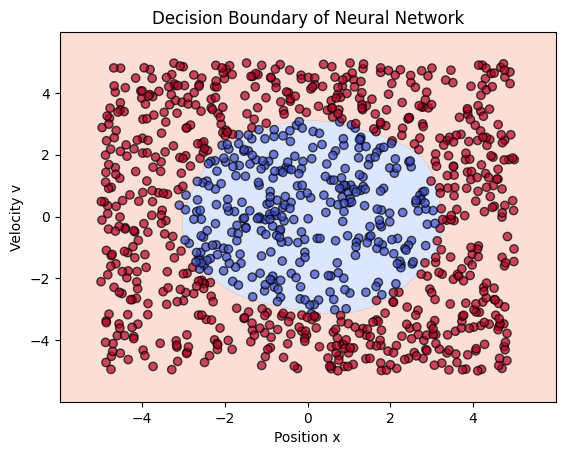

In [ ]:
def plot_decision_boundary(model, X, y, steps=200, cmap='coolwarm'):
    # Define the grid
    x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, steps),
                         np.linspace(y_min, y_max, steps))

    # Prepare grid points for model
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_tensor = torch.FloatTensor(grid)

    # Predict with model (detach to numpy)
    with torch.no_grad():
        preds = model(grid_tensor).cpu().numpy().reshape(xx.shape)

    # Plot decision surface
    plt.contourf(xx, yy, preds, levels=[0,0.5,1], cmap=cmap, alpha=0.3)

    # Overlay training points
    plt.scatter(X[:,0], X[:,1], c=y, cmap=cmap, edgecolor='k', alpha=0.7)
    plt.xlabel("Position x")
    plt.ylabel("Velocity v")
    plt.title("Decision Boundary of Neural Network")
    plt.show()

# Example usage (assuming df and model are defined and trained):
X = df[['Position', 'Velocity']].values
y = df['Label'].values
plot_decision_boundary(model, X, y)

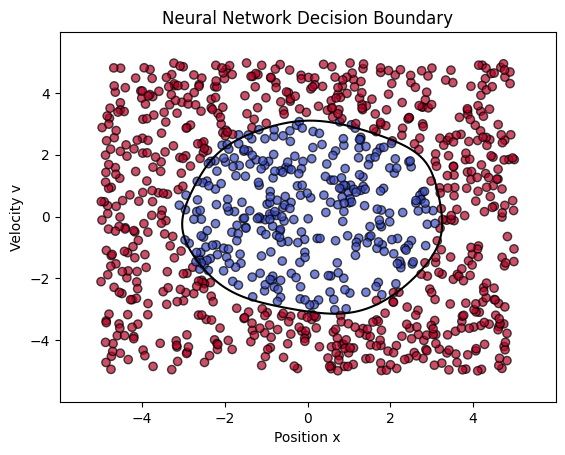

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def plot_boundary_line(model, X, y, steps=200, cmap='coolwarm'):
    # Define the grid
    x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, steps),
                         np.linspace(y_min, y_max, steps))

    # Predict probabilities on the grid
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_tensor = torch.FloatTensor(grid)
    with torch.no_grad():
        preds = model(grid_tensor).cpu().numpy().reshape(xx.shape)

    # Plot decision boundary (only the line at 0.5)
    plt.contour(xx, yy, preds, levels=[0.5], colors='k')

    # Overlay scatter points
    plt.scatter(X[:,0], X[:,1], c=y, cmap=cmap, edgecolor='k', alpha=0.7)
    plt.xlabel("Position x")
    plt.ylabel("Velocity v")
    plt.title("Neural Network Decision Boundary")
    plt.show()

# Example usage
X = df[['Position', 'Velocity']].values
y = df['Label'].values
plot_boundary_line(model, X, y)
